**`학습 내용 요약`**
- MNIST 숫자 데이터를 사용하여 여러 차원 축소 알고리즘을 실습해보고 시각화하여 비교하기

1) 일반 PCA, 점진적 PCA, 희소 PCA, 커널 PCA

2) 특잇값 분해(SVD)

3) 랜덤 투영 - GRP, SRP

4) Isomap

5) 다차원 스케일링(MDS)

6) 지역선형임베딩(LLE)

7) t분포 확률적 임베딩(t-SNE)

8) 사전학습


**`데이터 요약`**

- MNIST 숫자 데이터 베이스
- 얀르쿤의 웹 사이트에서 공개적으로 사용할 수 있는 MNIST 데이터셋 버전
- deeplearning.net이 제공하는 피클 버전
- 훈련셋 50,000건, 검증셋 10,000건, 테스트셋 10,000건
- 데이터셋은 28x28 픽셀 크기으 ㅣ손으로 쓴 숫자 글씨 이미지

In [43]:
# 라이브러리 불러오기
"""메인 라이브러리"""
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

"""시각화 관련 라이브러리"""
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline

"""데이터 준비 및 모델 평가 관련 라이브러리"""
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve,auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

"""알고리즘 관련 라이브러리"""
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb


### 1. MNIST 데이터셋 로드하기

In [44]:
# 데이터셋 로드하기
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'mnist_data', 'mnist.pkl.gz'])

f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding = 'latin1')
f.close()

x_train, y_train = train_set[0], train_set[1]
x_validation, y_validation = validation_set[0], validation_set[1]
x_test, y_test = test_set[0], test_set[1]

### 2. 데이터셋 구조 확인하기

In [45]:
# 데이터셋 구조 확인하기
print("Shape of x_train : ", x_train.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of x_validation : ", x_validation.shape)
print("Shape of y_validation : ", y_validation.shape)
print("Shape of x_test : ", x_test.shape)
print("Shape of y_test : ", y_test.shape)

Shape of x_train :  (50000, 784)
Shape of y_train :  (50000,)
Shape of x_validation :  (10000, 784)
Shape of y_validation :  (10000,)
Shape of x_test :  (10000, 784)
Shape of y_test :  (10000,)


In [46]:
# 넘파이배열을 판다스 데이터 프레임으로 변환
train_index = range(0, len(x_train))
validation_index = range(len(x_train), len(x_train)+len(x_validation))
test_index = range(len(x_train)+len(x_validation),len(x_train)+len(x_validation)+len(x_test))

x_train = pd.DataFrame(data=x_train, index=train_index)
y_train = pd.Series(data=y_train, index = train_index)

x_validation = pd.DataFrame(data=x_validation, index=validation_index)
y_validation = pd.Series(data=y_validation, index=validation_index)

x_test = pd.DataFrame(data=x_test, index=test_index)
y_test = pd.DataFrame(data=y_test, index=test_index)

In [47]:
# 데이터 요약 결과
x_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992188,0.992188,0.988281,0.988281,0.992188,0.242188,0.0,0.0,0.0,0.0


In [48]:
# 레이블 데이터 보기
y_train.head()

0    5
1    0
2    4
3    1
4    9
dtype: int64

In [7]:
# 이미지 시각화하기
def view_digit(example):
    label = y_train.loc[0]
    image = x_train.loc[example, :].values.reshape([28,28])
    plt.title('Example : %d  Lable : %d' %(example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

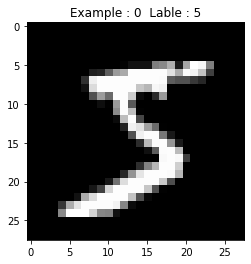

In [8]:
view_digit(0)

### 2. 차원 축소 알고리즘

#### 1) PCA

In [51]:
# 하이퍼파라미터 설정하기
from sklearn.decomposition import PCA

n_componets = 784
whiten = False
random_state = 2018

pca = PCA(n_components = n_componets, whiten = whiten, random_state = random_state)

# PCA 적용하기
x_train_pca = pca.fit_transform(x_train)
x_train_pca = pd.DataFrame(data=x_train_pca, index = train_index)

# PCA 평가하기
#-- 784개 주성분에 의해 설명되는 분산 비율
print("Variance Explained by all 784 principal components : ", sum(pca.explained_variance_ratio_))

Variance Explained by all 784 principal components :  1.0000000533228808


> 주성분 개수를 원본 데이터의 차원(784)수로 설정하였기 때문에 추출한 원본 데이터의 분산/정보는 100%가 되어야합니다. 

In [11]:
# x개 주성분에 의해 설명되는 분산 비율
importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 10 Principal Components : ',
     importanceOfPrincipalComponents.loc[:, 0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components : ',
     importanceOfPrincipalComponents.loc[:, 0:19].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components : ',
     importanceOfPrincipalComponents.loc[:, 0:49].sum(axis=1).values)
print('Variance Captured by First 100 Principal Components : ',
     importanceOfPrincipalComponents.loc[:, 0:99].sum(axis=1).values)
print('Variance Captured by First 200 Principal Components : ',
     importanceOfPrincipalComponents.loc[:, 0:199].sum(axis=1).values)
print('Variance Captured by First 300 Principal Components : ',
     importanceOfPrincipalComponents.loc[:, 0:299].sum(axis=1).values)

Variance Captured by First 10 Principal Components :  [0.48876014]
Variance Captured by First 20 Principal Components :  [0.64397836]
Variance Captured by First 50 Principal Components :  [0.8248599]
Variance Captured by First 100 Principal Components :  [0.91465807]
Variance Captured by First 200 Principal Components :  [0.96650064]
Variance Captured by First 300 Principal Components :  [0.9862489]


> 처음 10개 주성분이 총 분산의 약 50%를 잡아내고, 100개 주성분이 90% 이상, 300개 주성분이 총 분산의 99%를 잡아냅니다.
나머지 주성분의 정보는 무시할 수 있는 값입니다. 

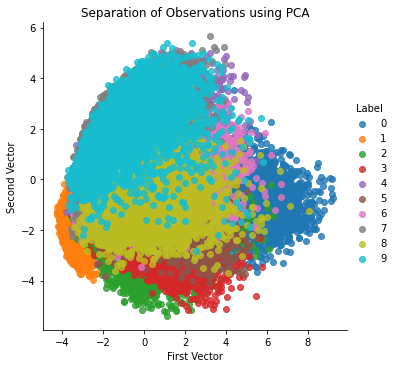

In [12]:
# PCA로 데이터 분리해서 시각화하기
def scatterPlot(xdf, ydf, algoName):
    tempdf = pd.DataFrame(data=xdf.loc[:, 0:1], index=xdf.index)
    tempdf = pd.concat([tempdf, ydf], axis=1, join='inner')
    tempdf.columns = ['First Vector', 'Second Vector', 'Label']
    
    sns.lmplot(x='First Vector', y='Second Vector', hue = 'Label', data=tempdf, fit_reg = False)
    ax = plt.gca()
    ax.set_title('Separation of Observations using '+algoName)
    
scatterPlot(x_train_pca, y_train, "PCA")

> 상위 두 개 주성분만 사용해 전반적으로 비슷한 데이터들이 서로 더 가까워지도록 데이터 포인트들을 잘 분리해냅니다. 

#### 2) 점진적 PCA

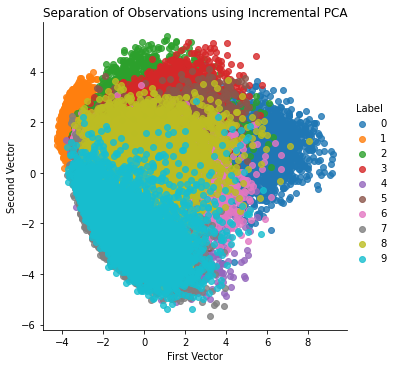

In [13]:
from sklearn.decomposition import IncrementalPCA

n_components = 784
batch_size = None

incrementalPCA = IncrementalPCA(n_components = n_components, batch_size=batch_size)

x_train_incrementalPCA = incrementalPCA.fit_transform(x_train)
x_train_incrementalPCA = pd.DataFrame(data=x_train_incrementalPCA, index=train_index)

x_validation_incrementalPCA = incrementalPCA.transform(x_validation)
x_validation_incrementalPCA = pd.DataFrame(data=x_validation_incrementalPCA, index=validation_index)

scatterPlot(x_train_incrementalPCA, y_train, "Incremental PCA")

> 데이터셋의 크기가 매우 커서 메모리에 저장할 수 없는 경우, 메모리에 저장되는 크기로  배치를 작게 설정해 점진적으로 PCA를 수행할 수 있습니다. 배치크기는 수동으로 설정하거나 자동으로 결정할 수 있습니다.
일반 PCA와 점진적 PCA와 주성분 결과는 일반적으로 매우 유사합니다.

#### 3) 희소 PCA

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.418576,-1.304891,-0.051351,-2.037982,0.150932,-1.128363,0.663776,-0.590313,1.375906,-0.811605,...,-0.116411,0.155188,0.031559,0.158866,0.214592,-0.071529,0.126498,-0.273586,0.233380,-0.497424
1,-3.970273,-1.474947,2.070492,-1.659645,-3.103568,-0.753760,-0.295728,0.522174,-0.289921,-0.280074,...,-0.178673,0.515635,-0.183799,-0.216256,-0.118874,0.047214,0.124608,0.228332,0.114306,-0.085561
2,0.161325,1.567018,-1.019342,1.765051,-1.154209,0.507981,-3.494799,-1.442896,0.215208,0.592432,...,0.093745,-0.310791,0.283374,0.026986,0.217237,-0.055393,-0.148267,0.300742,-0.053875,0.185252
3,3.420222,-2.197759,0.784491,0.442491,-0.478482,2.823964,-1.096710,0.589752,-1.313351,0.461944,...,-0.033281,0.089101,-0.072718,-0.036559,-0.016416,-0.020630,0.034806,0.199367,-0.255819,0.178072
4,1.318069,2.862465,0.053787,-0.957849,0.437383,0.115790,-0.259829,1.631609,-0.959698,-0.477799,...,-0.481322,-0.279890,0.344634,0.009143,0.247088,-0.010802,-0.280397,0.186545,-0.192619,-0.076960


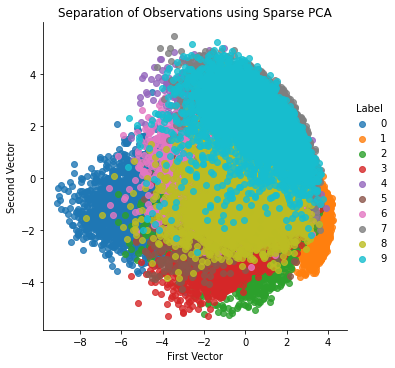

In [16]:
from sklearn.decomposition import SparsePCA

n_components = 100
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components = n_components, alpha = alpha, random_state = random_state, n_jobs = n_jobs)

sparsePCA.fit(x_train.loc[:10000, :])
x_train_sparsePCA = sparsePCA.transform(x_train)
x_train_sparsePCA = pd.DataFrame(data=x_train_sparsePCA, index = train_index)

x_validation_sparsePCA = sparsePCA.transform(x_validation)
x_validation_sparsePCA = pd.DataFrame(data=x_validation_sparsePCA, index = validation_index)

display(x_train_sparsePCA.head())

scatterPlot(x_train_sparsePCA, y_train, "Sparse PCA")

> 일반 PCA 알고리즘은 모든 입력 변수에서 선형 결합을 탐색해 원본 피처 공간을 최대한 조밀하게 줄입니다. 그러나 일부 머신러닝 문제의 경우 어느 정도의 희소성이 선호될 수 있습니다. 알파라는 하이퍼파라미터로 제어함으로써 희소성을 어느 정도 유지하는 PCA 버전을 희소 PCA라고 합니다. 

> 이 알고리즘은 일반 PCA보다 훈련 속도가 느리기 때문에 훈련 데이터셋의 처음 10,000개 케이스만 훈련시켰습니다.

#### 4) 커널 PCA

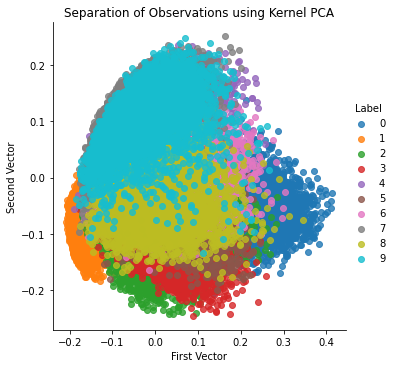

In [22]:
from sklearn.decomposition import KernelPCA

n_components = 100
kernel = 'rbf'
gamma = None
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components = n_components, kernel = kernel, gamma = gamma, n_jobs = n_jobs, random_state = random_state)

kernelPCA.fit(x_train.loc[:10000, :])
x_train_kernelPCA = kernelPCA.transform(x_train)
x_train_kernelPCA = pd.DataFrame(data = x_train_kernelPCA, index = train_index)

x_validation_kernelPCA = kernelPCA.transform(x_validation)
x_validation_kernelPCA = pd.DataFrame(data=x_validation_kernelPCA, index = validation_index)

scatterPlot(x_train_kernelPCA, y_train, "Kernel PCA")

> 일반 PCA, 점진적 PCA, 희소 PCA는 원본 데이터를 저차원 공간에 선형으로 투영하지만, 비선형 PCA 유형 중 하나인 커널 PCA는 원본 데이터 포인트 쌍들에 대해 유사성 함수를 실행시켜 비선형적으로 차원을 축소합니다. 
이 방법은 원본 피처셋을 선형으로 분리할 수 없는 경우에 특히 효과적입니다. 

> 이전 선형PCA 중 하나와 결과가 거의 동일하며 RBF 커널을 사용해도 차원 축소 결과는 개선되지 않았습니다.

#### 5) 특잇값 분해(SVD)

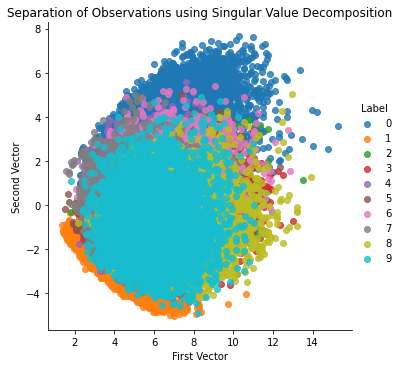

In [24]:
from sklearn.decomposition import TruncatedSVD

n_components = 200
algorithm = 'randomized'
n_iter = 5
random_state = 2018

svd = TruncatedSVD(n_components = n_components, algorithm = algorithm, n_iter = n_iter, random_state = random_state)

x_train_svd = svd.fit_transform(x_train)
x_train_svd = pd.DataFrame(data=x_train_svd, index = train_index)

x_validation_svd = svd.transform(x_validation)
x_validation_svd = pd.DataFrame(data = x_validation_svd, index = validation_index)

scatterPlot(x_train_svd, y_train, "Singular Value Decomposition")

> 데이터의 내재된 구조를 학습하는 또 다른 방법은 원본 행렬의 계수를 더 작은 계수로 줄이고 더 작은 계수 행렬에서 일부 벡터의 선형 결합을 사용해 원본 행렬을 다시 만들 수 있도록 하는 겁니다. 이를 특잇값 분해(SVD)라고 합니다. 

#### 6) 가우시안 랜덤 투영(GRP)

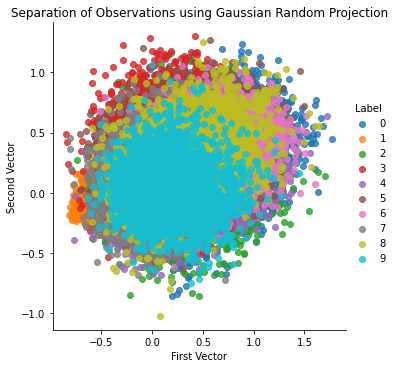

In [27]:
from sklearn.random_projection import GaussianRandomProjection

n_components = 'auto'
eps = 0.5
random_state = 2018

GRP = GaussianRandomProjection(n_components = n_components, eps = eps, random_state = random_state)

x_train_GRP = GRP.fit_transform(x_train)
x_train_GRP = pd.DataFrame(data = x_train_GRP, index = train_index)

x_validation_GRP = GRP.transform(x_validation)
x_validation_GRP = pd.DataFrame(data = x_validation_GRP, index = validation_index)

scatterPlot(x_train_GRP, y_train, "Gaussian Random Projection")

> 또 다른 선형 타원 축소 기법은 존슨-린덴슈트라우스 보조정리 기반의 랜덤 투영이 있습니다. 존슨-린덴슈트라우스 보조정리에 따르면, 고차원 공간의 데이터 포인트들은 포인트 사이의 거리가 거의 보존되는 방식으로 훨씬 더 낮으 ㄴ차원의 공간에 삽입될 수 있습니다. 
즉, 고차원 공간에서 저차원 공간으로 이동하는 경우에도 원본 피처셋의 핵심 정보가 유지됩니다. 

> 랜덤 투영에는 두 가지 버전이 있습니다. 일반 버전인 가우시안 랜덤 투영(GRP)와 희소 버전인 희소 랜덤 투영(SRP)입니다. 
가우시안 랜덤 투영의 경우 축소된 피처 공간에 갖고 싶은 주성분의 수를 설정하거나 하이퍼파라미터인 입실론을 설정할 수 있습니다. eps는 존슨-린덴슈트라우스 보조정리에 따라 임베딩의 품질을 제어하며 이 값이 작을수록 차원의 수가 높아집니다.

> 랜덤 투영은 PCA와 같은 선형 투영의 한 유형이지만, 완전히 다른 계열의 차원 축소 기법입니다. 따라서 랜덤 투영 산점도는 앞선 PCA 산점도들과 매우 다르게 보입니다.

#### 7) 희소 버전(SRP)

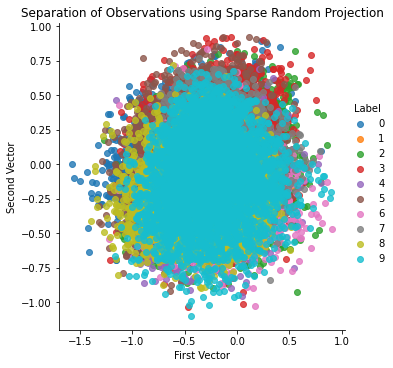

In [29]:
from sklearn.random_projection import SparseRandomProjection

n_components = 'auto'
density = 'auto'
eps = 0.5
dense_output = False
random_state = 2018

SRP = SparseRandomProjection(n_components = n_components, density = density, eps = eps, dense_output = dense_output, random_state = random_state)

x_train_SRP = SRP.fit_transform(x_train)
x_train_SRP = pd.DataFrame(data = x_train_SRP, index = train_index)

x_validation_SRP = SRP.transform(x_validation)
x_validation_SRP = pd.DataFrame(data = x_validation_SRP, index = validation_index)

scatterPlot(x_train_SRP, y_train, "Sparse Random Projection")

> 희소 랜덤 투영은 번환된 피처셋에서 어느 정도의 희소성을 유지하며 일반적으로 가우시안 랜덤 투영보다 훨씬 빠르게 원본 데이터를 축소된 공간으로 변환시킴으로써 훨씬 효율적입니다. 

#### 8) Isomap

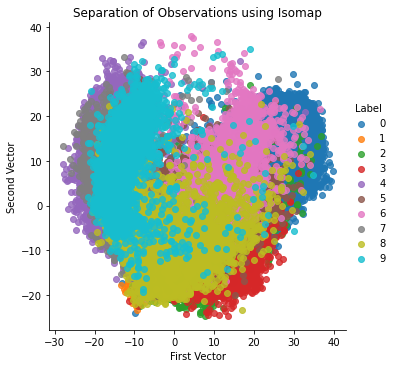

In [30]:
from sklearn.manifold import Isomap

n_neighbors = 5
n_components = 10
n_jobs = 4

isomap = Isomap(n_neighbors = n_neighbors, n_components = n_components, n_jobs = n_jobs)

isomap.fit(x_train.loc[:5000, :])
x_train_isomap = isomap.transform(x_train)
x_train_isomap = pd.DataFrame(data = x_train_isomap, index = train_index)

x_validation_isomap = isomap.transform(x_validation)
x_validation_isomap = pd.DataFrame(data = x_validation_isomap, index = validation_index)

scatterPlot(x_train_isomap, y_train, "Isomap")

> 고차원 공간에서 저차원 공간으로 데이터를 선형으로 투영하는 대신 비선형 차원 축소 방법을 사용할 수 있습니다. 이러한 방법을 통상적으로 매니폴드 학습이라고 합니다. 
isomap은 유클리드 거리가 아닌 곡선 거리 또는 지오데식 거리로 모든 데이터 포인트 간의 쌍별 거리를 계산해 원본 피처셋의 새로운 저차원 임베딩을 학습합니다. 

#### 9) 다차원 스케일링(MDS)

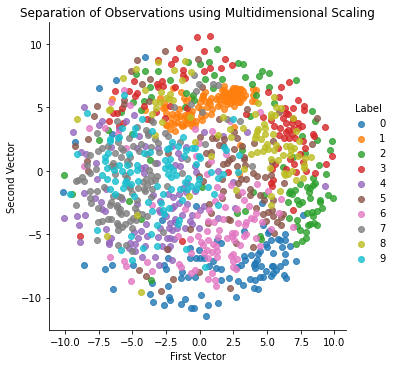

In [31]:
from sklearn.manifold import MDS

n_components = 2
n_init = 12
max_iter = 1200
metric = True
n_jobs = 4
random_state = 2018

mds = MDS(n_components = n_components, n_init = n_init, max_iter = max_iter, metric = metric, n_jobs = n_jobs, random_state = random_state)

x_train_mds = mds.fit_transform(x_train.loc[:1000, :])
x_train_mds = pd.DataFrame(data = x_train_mds, index = train_index[:1001])

scatterPlot(x_train_mds, y_train, 'Multidimensional Scaling')

> 비선형 차원 축소의 한 유형으로 원본 데이터셋에서 데이터 포인트들의 유사성을 학습하고, 이 유사성 학습 결과를 사용해 더 낮은 차원 공간에서 이것을 모델링합니다.

#### 10) 지역 선형 임베딩(LLE)

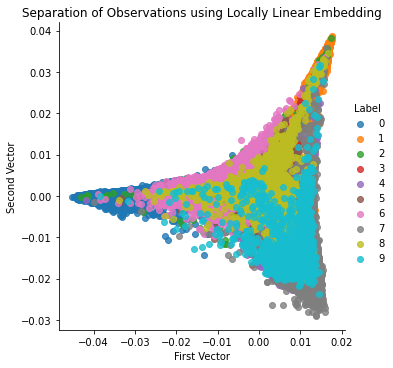

In [49]:
from sklearn.manifold import LocallyLinearEmbedding

n_neighbors = 10
n_components = 2
method = 'modified'
n_jobs = 4
random_state = 2018

lle = LocallyLinearEmbedding(n_neighbors = n_neighbors, n_components = n_components, method = method, random_state = random_state, n_jobs = n_jobs)

lle.fit(x_train.loc[:5000, :])
x_train_lle = lle.transform(x_train)
x_train_lle = pd.DataFrame(data = x_train_lle, index = train_index)

x_validation_lle = lle.transform(x_validation)
x_validation_lle = pd.DataFrame(data = x_validation_lle, index = validation_index)

scatterPlot(x_train_lle, y_train, "Locally Linear Embedding")

> 널리 사용하는 또 다른 비선형 차원 축소 방법으로는 지역 선형 임베딩(LLE)이 있습니다. 이 방법은 원본 피처 공간에서 축소된 공간으로 데이터를 투영할 때 지역 내 이웃과의 거리를 유지합니다. LLE는 데이터를 더 작은 성분으로 분할하고 각 성분을 선형 임베딩으로 모델링해 원본 고차원 데이터에서 비선형 구조를 발견합니다. 
이 알고리즘에서는 우리가 원하는 성분의 수와 주어진 이웃에서 고려해야할 포인트 수를 설정합니다.

#### 11) t-분포 확률적 임베딩(t-SNE)

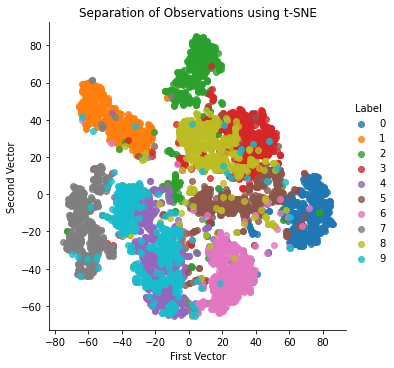

In [52]:
from sklearn.manifold import TSNE

n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration = 12
init = 'random'
random_state = 2018

tSNE = TSNE(n_components = n_components, learning_rate = learning_rate, perplexity = perplexity, early_exaggeration = early_exaggeration, init = init, random_state = random_state)

x_train_tSNE = tSNE.fit_transform(x_train_pca.loc[:5000, :9])
x_train_tSNE = pd.DataFrame(data = x_train_tSNE, index = train_index[:5001])

scatterPlot(x_train_tSNE, y_train, "t-SNE")

> 고차원 데이터를 시각화하기 위한 비선형 차원 축소 기법으로 각 고차원 데이터 포인트를 2차원 또는 3차원 공간으로 모델링해 이를 수행합니다.
이는 포인트 쌍들을 높은 확률값을 가지고 유사하지 않은 포인트들은 낮은 확률값을 가지게 됩니다.특히 t-SNE는 두 확률 분포간 쿨백-라이블러발산(KLD)를 최소화합니다.

> t-SNE를 실제로 적용할 때는 PCA와 같은 다른 차원 축소 기술을 사용해 차원의 수를 줄인 다음에 사용하는 것이 가장 좋습니다. 

> 다른 유형의 차원 축소를 먼저 적용함으로써 t-SNE에 공급되는 피처의 노이즈를 줄이고 알고리즘 계산 속도를 높입니다. 

#### 12) 사전학습

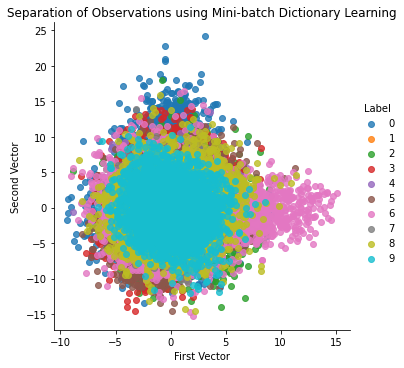

In [54]:
from sklearn.decomposition import MiniBatchDictionaryLearning

n_components = 50
alpha = 1
batch_size = 200
n_iter = 25
random_state = 2018

miniBatchDictLearning = MiniBatchDictionaryLearning(n_components = n_components, alpha = alpha, batch_size = batch_size, n_iter=n_iter, random_state = random_state)

miniBatchDictLearning.fit(x_train.loc[:,:10000])
x_train_miniBatchDictLearning = miniBatchDictLearning.fit_transform(x_train)
x_train_miniBatchDictLearning = pd.DataFrame(data = x_train_miniBatchDictLearning, index = train_index)

x_validation_miniBatchDictLearning = miniBatchDictLearning.transform(x_validation)
x_validation_miniBatchDictLearning = pd.DataFrame(data = x_validation_miniBatchDictLearning, index = validation_index)

scatterPlot(x_train_miniBatchDictLearning, y_train, "Mini-batch Dictionary Learning")

In [ ]:
>  어떤 종류의 기하학적 구조나 거리 척도에도 의존하지 않는 방법 중 하나로 원본 데이터의 희소 표현을 학습하는 사전학습이 있습니다. 결과 행렬은 사전이라고 하며, 이 사전을 구성하는 벡터를 원자라고 합니다. 

> 이 원자는 0과 1로 채워진 간단한 이진 벡터입니다. 원본 데이터의 각 인스턴스는 이러한 원자의 가중 합으로 재구성될 수 있습니다. 

> 원본데이터에 d 피처가 있고 사전에 n개 원자가 있다고 가정하면, n<d인 과소완전 사전 혹은 n>d인 과대완전 사전을 가질 수 있습니다.
과소완전사전은 더 적은 수의 벡터로 원본 데이터를 재표현합니다. 